# Decoding temporal structure in narratives using functional connectivity pattern 


<br>

* 전처리 및 Denoising Step이 끝나고 영상별/구획별로 재구성된 연결성 패턴을 대상으로 분석을 수행한다. 
* MVPA 섹션에서는 참가자 내 영상 간 구획별 분류 여부, 참가자 간 구획별 분류 여부에 대한 분석을 수행한다.
* Network Analysis 섹션에서는 각 참가자별로 영상별/구획별 패턴에서 FC value와 Netwrok Measure를 측정한다.
* 모든 분석은 참가자들이 성실히 보고 제대로 이해한 영상을 대상으로만 수행된다.

# Preparation

## Load Library

In [2]:
### Data Handling & Analysis
#!pip install numpy scipy pandas sympy statsmodels
#!conda install numpy scipy pandas sympy statsmodels

### Plot
#!pip install matplotlib seaborn plotnine bokeh
#!conda install matplotlib seaborn plotnine bokeh

### ML & DL
#!pip install scikit-learn tensorflow keras
#!conda install scikit-learn tensorflow keras

### network analysis
#!pip install bctpy networkx nilearn

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import bct as bct
from copy import deepcopy


import pingouin as pg
import scipy as sp
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from nilearn.plotting import plot_connectome, view_connectome, plot_matrix

import pylab as pl
import qgrid
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import KFold, LeaveOneOut, LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score #prediction
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate #prediction
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import permutation_test_score
# from xgboost import XGBClassifier

# Display HTML
from IPython.core.display import display, HTML

# 노트북 안에 그래프를 그리기
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')

# 그래프에서 한글 폰트 및 마이너스 폰트 깨지는 문제를 대처
plt.rc('font', family='AppleGothic') # For Windows
plt.rcParams['figure.figsize'] = [13, 7]
mpl.rcParams['axes.unicode_minus'] = False


# 그래프 글자 크기 조정
plt.rc('font', family='AppleGothic') # For Windows
plt.rc('font', size = 15)

sOpt = 3;

import warnings
warnings.filterwarnings(action='ignore')

/Users/taehoonkim/miniforge3/envs/th/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
os.getcwd()

'/Users/taehoonkim/Desktop/Workspace/git_project/aniFCnet_Py_R'

In [5]:
currDir = os.getcwd()
os.chdir(currDir)
# os.chdir(r'/Users/taehoonkim/Desktop/Workspace/Python/anime/results')

## Load Behavior Data 

* 제대로 본/맞은 영상만 분석에 포함하기 위해 행동 검사 측정치를 불러오고 요약한다. 

In [6]:
bh = pd.read_csv('data/aniFCnet_behav.csv')
bh = bh.loc[:, ['sn', 'stimIdx', 'correctness', 'scores', 'check']] 
bh.columns = ['sn', 'idx', 'corr', 'socres', 'check']

* 실험 중 드랍한 12번 참가자의 결과는 제외한다. 

In [7]:
bh = (bh
      .query('sn != 12'))

In [19]:
bh

,sn,idx,corr,socres,check
0,1,2,1,9,0
1,1,9,1,9,0
2,1,10,0,1,1
3,1,13,0,1,1
4,1,15,1,7,0
...,...,...,...,...,...
625,21,222,1,4,0
626,21,230,1,7,0
627,21,234,1,8,0
628,21,235,0,6,0


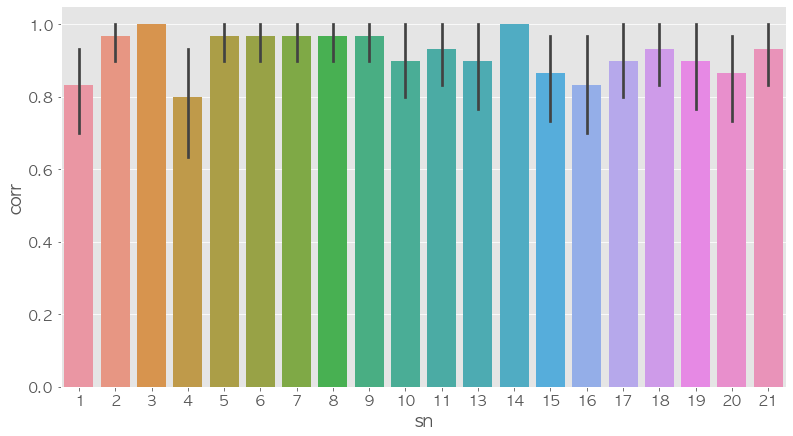

In [20]:
sns.barplot(data=bh , x="sn", y="corr")
plt.show()

## Load Network Info

* 네트워크 정보를 포함한 분석을 위해 각 edge들이 어떤 네트워크에 속하는지를 표시한 데이터를 불러온다.

In [21]:
net_df = pd.read_csv('net9_edge_py.csv')
print(net_df.head())

net_idx = ['Vis', 'SM', 'Cont', 
           'Sal/VA', 'DAN', 'DMN', 
           'TP', 'Limb', 'SubCor']
net_nidx = [1, 2, 3, 4, 5, 6, 7, 9, 0]
net_df_label = np.unique(net_df['netName'])
net_df_num = np.unique(net_df['net'])
print(net_df_num)
print(net_df_label)

   num  sN  eN  Type  net netName
0    1   1   1     1    1     Vis
1    2   1   1     1    1     Vis
2    3   1   1     1    1     Vis
3    4   1   1     1    1     Vis
4    5   1   1     1    1     Vis
[0 1 2 3 4 5 6 7 8 9]
['DAN' 'DMN' 'FPN' 'Limbic' 'SM' 'SubCor' 'TP' 'VAN' 'Vis' 'btw']


In [22]:
net_df_label

array(['DAN', 'DMN', 'FPN', 'Limbic', 'SM', 'SubCor', 'TP', 'VAN', 'Vis',
       'btw'], dtype=object)

In [23]:
net_df.netName

0          Vis
1          Vis
2          Vis
3          Vis
4          Vis
         ...  
7376    SubCor
7377    SubCor
7378    SubCor
7379    SubCor
7380    SubCor
Name: netName, Length: 7381, dtype: object

In [24]:
net_loc = np.array(net_df.net)
net_loc_df = pd.DataFrame(net_loc)
net_loc_df.columns = ['loc']
print(net_loc)

net_loc_name = np.array(net_df.netName)
net_loc_name = pd.DataFrame(net_loc_name)
net_loc_name.columns = ['loc']
np.unique(net_loc_name)

[1 1 1 ... 9 9 9]


array(['DAN', 'DMN', 'FPN', 'Limbic', 'SM', 'SubCor', 'TP', 'VAN', 'Vis',
       'btw'], dtype=object)

## Load sFC Data

* 재구성된 패턴 자료를 불러온다. 

In [25]:
input_name = ('rs_sFC_opt%d.csv' % (sOpt))
data = pd.read_csv(input_name)

In [26]:
data.shape

(1260, 7385)

In [27]:
(data
 .filter(['sn','idx','run', 'con'])
 .groupby(['con'])
 .agg('count'))

,sn,idx,run
con,,,
1,630,630,630
2,630,630,630


# MVPA

In [28]:
subj_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]

## Subject-Level

* 참가자 내에서, 서로 다른 영상 간에서 연결성 패턴을 구획별로 분류할 수 있는지를 살펴본다. 
* 분석 모델에 따른 차이를 확인하기 위해 Ridge, l2 penalty Logistic Regression, linearSVM을 사용하였다.  
* 서로 다른 영상 간 분류 정확도를 확인하기 위해 Run 을 Index로 Leave-one-group-out 메서드를 활용하여 Run별 Train & Validation을 수행한다. 
* 연속형 Feature의 속성을 고려하여 Feature 별 Standardization(Z-scoring)을 수행하였다.
* Performance Metric은 Accuracy와 AUC를 사용하였다. 
* 요약치는 전체 런에 걸친 개별 참가자 내의 분류 정확도를 나타낸다. 

In [29]:
# standardization method, 1 - case, 2 - feature, 3 - none
# std_list = [1, 2, 3]
std_list = [2]
#net_nidx = [10, 0, 1, 2, 3, 4, 5, 6, 7, 9]
net_nidx = [10, 0, 1, 2, 3, 4, 5, 6, 7, 9]
opt_list = [1, 2, 3, 4]
opt_list = [1, 2, 3]
# opt_list = [1]

for std_opt in std_list:
    results_sum = [];
    x_subj = [];
    x_net = [];
    x_classifier = [];
    x_valid_acc = [];
    x_p1_acc = [];
    x_p2_acc = [];
    x_auc = [];
    x_p1_auc = [];
    x_p2_auc = [];
    output_name = ('sFC_mvpc_subj_opt%d_std%d.csv' % (sOpt, std_opt))
    
    for sidx, subj in enumerate(subj_idx):
        
        # step 1
        df_1 = deepcopy(data[data['sn']==subj])
        bh_t = bh[bh['sn']==subj]
        df_2 = pd.merge(bh_t, df_1, on = ['sn','idx'])
        df_3 = df_2[(df_2['con']>0) & (df_2['corr']==1)]
        
        # step 2
        x_raw = np.array(df_3.loc[:,"v1":])
        x_raw = x_raw.astype('float32')        
        
        y_train = np.array(df_3.loc[:,"con"])
        y_train = y_train.astype('int')        
        
        groups = np.array(df_3.loc[:,"run"]) # by run Group
        groups.astype('int')
        
        for net in net_nidx:
            
            if net == 10:
                x_train = deepcopy(x_raw)
            elif net != 10:
                x_train = deepcopy(x_raw[:,net_loc==net])
            
            # Standardization
            if std_opt == 1: # case standardization
                scaler = StandardScaler()
                x_train_z = np.transpose(x_train)
                x_train_z = scaler.fit_transform(x_train_z)
                x_train_z = np.transpose(x_train_z)
                x_train = x_train_z

            elif std_opt == 2: # feature standardization
                scaler = StandardScaler()
                x_train_z = scaler.fit_transform(x_train)
                x_train = x_train_z    
                
            elif std_opt == 3: # no standardization
                x_train = x_train

            x_train = np.nan_to_num(x_train, copy=False)
            
            
            for opt in opt_list:
                
                if opt == 1:
                    Classif = RidgeClassifier(alpha=10.0)
                    # class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, 
                    #                                            normalize=False, copy_X=True, 
                    #                                            max_iter=None, tol=0.001, 
                    #                                            class_weight=None, 
                    #                                            solver='auto', random_state=None)
                    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html?highlight=ridgeclassifier#sklearn.linear_model.RidgeClassifier

                elif opt == 2:
                    Classif = LogisticRegression(C=1.0, max_iter=1000,
                                                 solver='lbfgs', penalty='l2', tol=0.001)
#                                                  penalty="l2", solver="saga", l1_ratio=0.5,
#                                                  tol=0.001)
#                                                 penalty='l1', tol=0.001)  #1e5


                    #Classif = LogisticRegression(C=1.0, max_iter=10000, 
                    #                             penalty='elasticnet', tol=0.001,
                    #                            solver ='saga', multi_class='multinomial', 
                    #                             l1_ratio=0.5)  #1e5
                    # sklearn.linear_model.LogisticRegression(penalty='l2', *, 
                    #                                         dual=False, tol=0.0001, C=1.0, 
                    #                                         fit_intercept=True, intercept_scaling=1, 
                    #                                         class_weight=None, random_state=None, 
                    #                                         solver='lbfgs', max_iter=100, multi_class='auto', 
                    #                                         verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
                    # solver ='liblinear', solver ='saga'
                    
                elif opt == 3:
                    Classif = svm.SVC(kernel='linear')
                    # sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                    #               probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                    #               max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
                    # kfold = KFold(n_splits=10, random_state=5, shuffle=True)
                    # multi_class - 'ovr' for one vs rest; "crammer_singer" for all classes classification            


                elif opt == 4:
                    Classif = svm.SVC(kernel='rbf')
                    # sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, 
                    #               probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, 
                    #               max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
                    # kfold = KFold(n_splits=10, random_state=5, shuffle=True)
                    # multi_class - 'ovr' for one vs rest, 'ovo' for one vs one; "crammer_singer" for all classes classification



                ### training & validation
                print('-'*30)
                print('\nsubj %d, net %d, std %d, clasif %d' % (subj, net, std_opt, opt))
                print('\nshape x %s, y %s' % (x_train.shape, y_train.shape))

                # leave-one-group-out
                logo = LeaveOneGroupOut()
                y_aftrain = cross_val_predict(Classif, x_train, y_train, cv=logo, groups=groups)
                results_validate = cross_val_score(Classif, x_train, y_train, cv=logo, groups=groups)
                cv_results = cross_validate(Classif, x_train, y_train, cv=logo, groups=groups)
                valid_acc = accuracy_score(y_train, y_aftrain)*100.0

                tmp_subj=int(subj)
                tmp_net=int(net)        
                tmp_opt=int(opt)
                tmp_valid_acc=valid_acc


                p1_idx1 = y_train==1
                p2_idx1 = y_train==2

                p1_train = y_train[p1_idx1]
                p1_aftrain = y_aftrain[p1_idx1]

                p2_train = y_train[p2_idx1]
                p2_aftrain = y_aftrain[p2_idx1]

                tmp_p1_acc = accuracy_score(p1_train, p1_aftrain)*100.0
                tmp_p2_acc = accuracy_score(p2_train, p2_aftrain)*100.0


                y_train_bn = label_binarize(y_train, classes=[1,2])
                y_aftrain_bn = label_binarize(y_aftrain, classes=[1,2])
                auc_fnl = roc_auc_score(y_train_bn, y_aftrain_bn, average=None)

                x_subj.append(tmp_subj)
                x_net.append(tmp_net)
                x_classifier.append(tmp_opt)
                x_valid_acc.append(tmp_valid_acc)
                x_p1_acc.append(tmp_p1_acc)
                x_p2_acc.append(tmp_p2_acc)

                x_auc.append(auc_fnl*100.0)




    # final saving
    results_sum = pd.DataFrame({'subj': x_subj,
                                'net': x_net,
                                'classifier': x_classifier,                            
                                'valid_acc': x_valid_acc,
                                'p1_acc': x_p1_acc,
                                'p2_acc': x_p2_acc,
                                'auc': x_auc,})

    results_sum.to_csv(output_name, mode='w', index=False)

------------------------------

subj 1, net 10, std 2, clasif 1

shape x (50, 7381), y (50,)
------------------------------

subj 1, net 10, std 2, clasif 2

shape x (50, 7381), y (50,)
------------------------------

subj 1, net 10, std 2, clasif 3

shape x (50, 7381), y (50,)
------------------------------

subj 1, net 0, std 2, clasif 1

shape x (50, 6288), y (50,)
------------------------------

subj 1, net 0, std 2, clasif 2

shape x (50, 6288), y (50,)
------------------------------

subj 1, net 0, std 2, clasif 3

shape x (50, 6288), y (50,)
------------------------------

subj 1, net 1, std 2, clasif 1

shape x (50, 45), y (50,)
------------------------------

subj 1, net 1, std 2, clasif 2

shape x (50, 45), y (50,)
------------------------------

subj 1, net 1, std 2, clasif 3

shape x (50, 45), y (50,)
------------------------------

subj 1, net 2, std 2, clasif 1

shape x (50, 45), y (50,)
------------------------------

subj 1, net 2, std 2, clasif 2

shape x (50, 45), y (

------------------------------

subj 4, net 10, std 2, clasif 2

shape x (48, 7381), y (48,)
------------------------------

subj 4, net 10, std 2, clasif 3

shape x (48, 7381), y (48,)
------------------------------

subj 4, net 0, std 2, clasif 1

shape x (48, 6288), y (48,)
------------------------------

subj 4, net 0, std 2, clasif 2

shape x (48, 6288), y (48,)
------------------------------

subj 4, net 0, std 2, clasif 3

shape x (48, 6288), y (48,)
------------------------------

subj 4, net 1, std 2, clasif 1

shape x (48, 45), y (48,)
------------------------------

subj 4, net 1, std 2, clasif 2

shape x (48, 45), y (48,)
------------------------------

subj 4, net 1, std 2, clasif 3

shape x (48, 45), y (48,)
------------------------------

subj 4, net 2, std 2, clasif 1

shape x (48, 45), y (48,)
------------------------------

subj 4, net 2, std 2, clasif 2

shape x (48, 45), y (48,)
------------------------------

subj 4, net 2, std 2, clasif 3

shape x (48, 45), y (48,

------------------------------

subj 7, net 10, std 2, clasif 3

shape x (58, 7381), y (58,)
------------------------------

subj 7, net 0, std 2, clasif 1

shape x (58, 6288), y (58,)
------------------------------

subj 7, net 0, std 2, clasif 2

shape x (58, 6288), y (58,)
------------------------------

subj 7, net 0, std 2, clasif 3

shape x (58, 6288), y (58,)
------------------------------

subj 7, net 1, std 2, clasif 1

shape x (58, 45), y (58,)
------------------------------

subj 7, net 1, std 2, clasif 2

shape x (58, 45), y (58,)
------------------------------

subj 7, net 1, std 2, clasif 3

shape x (58, 45), y (58,)
------------------------------

subj 7, net 2, std 2, clasif 1

shape x (58, 45), y (58,)
------------------------------

subj 7, net 2, std 2, clasif 2

shape x (58, 45), y (58,)
------------------------------

subj 7, net 2, std 2, clasif 3

shape x (58, 45), y (58,)
------------------------------

subj 7, net 3, std 2, clasif 1

shape x (58, 325), y (58,)


------------------------------

subj 10, net 0, std 2, clasif 1

shape x (54, 6288), y (54,)
------------------------------

subj 10, net 0, std 2, clasif 2

shape x (54, 6288), y (54,)
------------------------------

subj 10, net 0, std 2, clasif 3

shape x (54, 6288), y (54,)
------------------------------

subj 10, net 1, std 2, clasif 1

shape x (54, 45), y (54,)
------------------------------

subj 10, net 1, std 2, clasif 2

shape x (54, 45), y (54,)
------------------------------

subj 10, net 1, std 2, clasif 3

shape x (54, 45), y (54,)
------------------------------

subj 10, net 2, std 2, clasif 1

shape x (54, 45), y (54,)
------------------------------

subj 10, net 2, std 2, clasif 2

shape x (54, 45), y (54,)
------------------------------

subj 10, net 2, std 2, clasif 3

shape x (54, 45), y (54,)
------------------------------

subj 10, net 3, std 2, clasif 1

shape x (54, 325), y (54,)
------------------------------

subj 10, net 3, std 2, clasif 2

shape x (54, 325),

------------------------------

subj 14, net 0, std 2, clasif 1

shape x (60, 6288), y (60,)
------------------------------

subj 14, net 0, std 2, clasif 2

shape x (60, 6288), y (60,)
------------------------------

subj 14, net 0, std 2, clasif 3

shape x (60, 6288), y (60,)
------------------------------

subj 14, net 1, std 2, clasif 1

shape x (60, 45), y (60,)
------------------------------

subj 14, net 1, std 2, clasif 2

shape x (60, 45), y (60,)
------------------------------

subj 14, net 1, std 2, clasif 3

shape x (60, 45), y (60,)
------------------------------

subj 14, net 2, std 2, clasif 1

shape x (60, 45), y (60,)
------------------------------

subj 14, net 2, std 2, clasif 2

shape x (60, 45), y (60,)
------------------------------

subj 14, net 2, std 2, clasif 3

shape x (60, 45), y (60,)
------------------------------

subj 14, net 3, std 2, clasif 1

shape x (60, 325), y (60,)
------------------------------

subj 14, net 3, std 2, clasif 2

shape x (60, 325),

------------------------------

subj 17, net 0, std 2, clasif 1

shape x (54, 6288), y (54,)
------------------------------

subj 17, net 0, std 2, clasif 2

shape x (54, 6288), y (54,)
------------------------------

subj 17, net 0, std 2, clasif 3

shape x (54, 6288), y (54,)
------------------------------

subj 17, net 1, std 2, clasif 1

shape x (54, 45), y (54,)
------------------------------

subj 17, net 1, std 2, clasif 2

shape x (54, 45), y (54,)
------------------------------

subj 17, net 1, std 2, clasif 3

shape x (54, 45), y (54,)
------------------------------

subj 17, net 2, std 2, clasif 1

shape x (54, 45), y (54,)
------------------------------

subj 17, net 2, std 2, clasif 2

shape x (54, 45), y (54,)
------------------------------

subj 17, net 2, std 2, clasif 3

shape x (54, 45), y (54,)
------------------------------

subj 17, net 3, std 2, clasif 1

shape x (54, 325), y (54,)
------------------------------

subj 17, net 3, std 2, clasif 2

shape x (54, 325),

------------------------------

subj 20, net 0, std 2, clasif 1

shape x (52, 6288), y (52,)
------------------------------

subj 20, net 0, std 2, clasif 2

shape x (52, 6288), y (52,)
------------------------------

subj 20, net 0, std 2, clasif 3

shape x (52, 6288), y (52,)
------------------------------

subj 20, net 1, std 2, clasif 1

shape x (52, 45), y (52,)
------------------------------

subj 20, net 1, std 2, clasif 2

shape x (52, 45), y (52,)
------------------------------

subj 20, net 1, std 2, clasif 3

shape x (52, 45), y (52,)
------------------------------

subj 20, net 2, std 2, clasif 1

shape x (52, 45), y (52,)
------------------------------

subj 20, net 2, std 2, clasif 2

shape x (52, 45), y (52,)
------------------------------

subj 20, net 2, std 2, clasif 3

shape x (52, 45), y (52,)
------------------------------

subj 20, net 3, std 2, clasif 1

shape x (52, 325), y (52,)
------------------------------

subj 20, net 3, std 2, clasif 2

shape x (52, 325),

In [30]:
results_sum['classifier'] = results_sum['classifier'].replace([1, 2, 3, 4],
                                                              ['ridge', 'logreg', 'lSVM', 'rbfSVM'])
results_sum['net'] = results_sum['net'].replace([10, 0, 1, 2, 3, 4, 5, 6, 7, 9],
                                    ['All', 'Btw', 'Vis', 'SM', 'FPN', 'VAN', 'DAN', 'DMN', 'Limbic', 'SubCor'])

results_sum.head(10)

,subj,net,classifier,valid_acc,p1_acc,p2_acc,auc
0,1,All,ridge,84.0,80.0,88.0,84.0
1,1,All,logreg,84.0,80.0,88.0,84.0
2,1,All,lSVM,84.0,80.0,88.0,84.0
3,1,Btw,ridge,84.0,80.0,88.0,84.0
4,1,Btw,logreg,84.0,84.0,84.0,84.0
5,1,Btw,lSVM,84.0,84.0,84.0,84.0
6,1,Vis,ridge,70.0,64.0,76.0,70.0
7,1,Vis,logreg,72.0,64.0,80.0,72.0
8,1,Vis,lSVM,70.0,68.0,72.0,70.0
9,1,SM,ridge,58.0,52.0,64.0,58.0


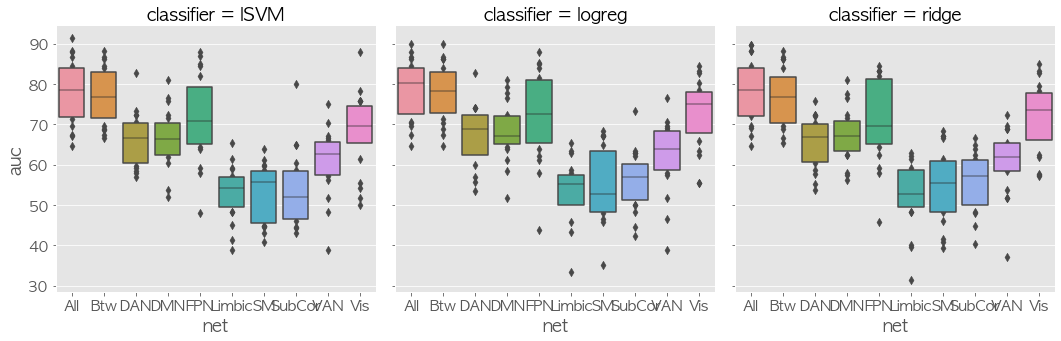

In [31]:
stdf2 = (results_sum
         .filter(['subj', 'classifier', 'net', 'auc'])
         .groupby(['subj', 'classifier', 'net'])
         .agg('mean')).reset_index()

g1 = sns.catplot(data=stdf2, x="net", y="auc", hue="net",
                 col="classifier", kind='boxen', dodge=False)
plt.tight_layout()
plt.show()

In [32]:
(stdf2
 .groupby(['classifier', 'net'])
 .agg('mean').reset_index()
 .pivot(index=['net'], columns='classifier', values='auc')
 .reset_index())


classifier,net,lSVM,logreg,ridge
0,All,78.213189,78.568453,78.478400
1,Btw,77.052536,77.942572,76.956382
2,DAN,66.380504,67.382813,65.497543
3,DMN,66.634535,68.441858,67.451395
4,FPN,71.677951,71.884700,71.521777
5,Limbic,53.027543,53.644248,52.594202
6,SM,53.454730,54.818806,54.653184
7,SubCor,53.990369,56.150642,55.755778
8,VAN,60.942770,62.030319,61.066516
9,Vis,68.241937,72.899812,71.877595


In [33]:
targX = stdf2[(stdf2['net']=="All") & (stdf2['classifier']=="ridge")]

In [34]:
pg.ttest(x=targX.auc, y=50, 
         alternative='two-sided', 
         correction='auto', 
         r=0.707, confidence=0.95)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,16.341629,19,two-sided,1.208630e-12,"[74.83, 82.13]",3.654099,5.782e+09,1.0


In [35]:
targX

,subj,classifier,net,auc
20,1,ridge,All,84.000000
50,2,ridge,All,89.655172
80,3,ridge,All,88.333333
110,4,ridge,All,64.583333
140,5,ridge,All,67.241379
170,6,ridge,All,84.482759
200,7,ridge,All,77.586207
230,8,ridge,All,89.655172
260,9,ridge,All,77.586207
290,10,ridge,All,83.333333


In [36]:
targX = stdf2[(stdf2['net']=="All")]
aov = pg.rm_anova(dv='auc', within='classifier',
                   subject='subj', data=targX, detailed=True)
aov.round(3)


,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,classifier,1.364,2,0.682,0.409,0.667,0.595,0.021,0.694,False,0.56,0.005
1,Error,63.385,38,1.668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


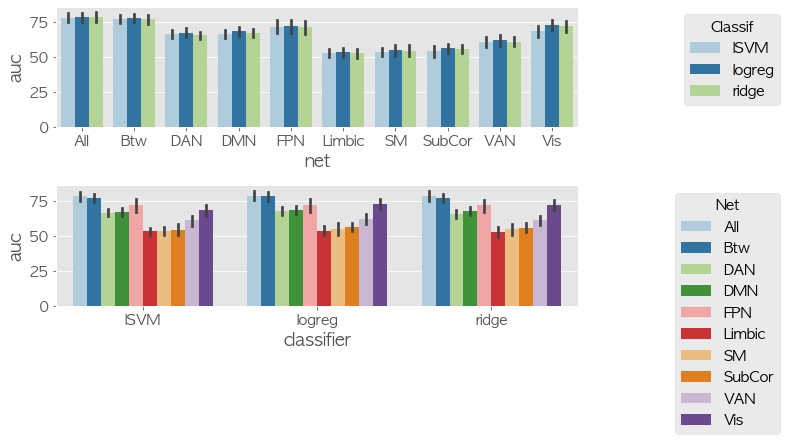

In [46]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 6))
g1 = sns.barplot(x="net", y="auc", hue="classifier", palette= "Paired",
                    data=stdf2, ax=axes[0])
g1.legend(loc='upper right', title='Classif',
         bbox_to_anchor=(1.4, 1))
g2 = sns.barplot(x="classifier", y="auc", hue="net",
                    data=stdf2, ax=axes[1], palette= "Paired")
g2.legend(loc='upper right', title='Net',
         bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.show()

## Group-Level

* 전체 참가자를 대상으로 참가자 간 서로 다른 구획별 패턴이 성공적으로 분류되는지 살펴본다. 
* 분석 모델로는 Ridge를 사용하였다. 
* 참가자 간 패턴 분류 방법은 아래와 같다.
    * 먼저 전체 20명의 참가자 중 19명을 Training set으로 구성하고, 나머지 한명을 Test set으로 구성한다. 
    * Standardization 방법으로는 Feature space에서 z-scoring을 수행한다. 
    * 19명의 Training Set에서는 Run 번호를 기준으로 Leave One Group Out 기법을 수행하여 Train & Validation을 수행한다. 
    * 이를 통해 모델 퍼포먼스를 확인하고 나머지 한명의 Test Set에 대하여 Test를 수행한다. 
    * 이 과정을 참가자별로 20번 반복하여 20명의 Target 참가자별로 Validation & Testing Accuracy를 산출한다

### Glimpse

In [47]:
# standardization method, 1 - case, 2 - feature, 3 - none
# std_list = [1, 2, 3]
std_list = [2]
net_nidx = [10, 1, 2, 3, 4, 5, 6, 7, 9]
# opt_list = [1, 2, 3, 4]
opt_list = [1]


In [ ]:
# standardization method, 1 - case, 2 - feature, 3 - none

## Parameters
vis = 1
net = 10
std_opt = 2

## Data Preparation
gdf_1 = pd.merge(bh, data, on = ['sn','idx'])
gdf_2 = gdf_1[(gdf_1['con']>0) & (gdf_1['corr']==1)]

## Data Preprocessing 
x_raw = np.array(gdf_2.loc[:,"v1":])
x_raw = x_raw.astype('float32')        
if net == 10:
    x_train = deepcopy(x_raw)
elif net != 10:
    x_train = deepcopy(x_raw[:,net_loc==net])

y_train = np.array(gdf_2.loc[:,"con"])
y_train = y_train.astype('int')        

groups = np.array(gdf_2.loc[:,"sn"]) # by Subject
groups = groups.astype('int')

if std_opt == 1: # case standardization 
    scaler = StandardScaler()
    x_train_z = np.transpose(x_train)
    x_train_z = scaler.fit_transform(x_train_z)
    x_train_z = np.transpose(x_train_z)
    x_train = x_train_z

elif std_opt == 2: # feature standardization 
    scaler = StandardScaler()
    x_train_z = scaler.fit_transform(x_train)
    x_train = x_train_z

elif std_opt == 3:    
    x_train = x_train
x_train = np.nan_to_num(x_train, copy=False)

## Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif
X_indices = np.arange(x_train.shape[-1]) # feature 인덱스를 반환한다.
selector = SelectKBest(f_classif, k="all") 
selector.fit(x_train, y_train)

# alpha = 0.05
alpha = 1
is_support = selector.pvalues_ < alpha
#bonf_corrected_alpha = alpha/len(X_indices)
#is_support = selector.pvalues_ < bonf_corrected_alpha
x_train_fs = x_train[:,is_support]

## Classifier Setting
Classif = RidgeClassifier(alpha=1.0)
# class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, 
#                                            normalize=False, copy_X=True, 
#                                            max_iter=None, tol=0.001, 
#                                            class_weight=None, 
#                                            solver='auto', random_state=None)
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html?highlight=ridgeclassifier#sklearn.linear_model.RidgeClassifier
# Classif = LogisticRegression(C=1, penalty='l1', tol=0.001, 
#                              multi_class = 'auto', solver='saga')


### training & validation for letter classification
logo = LeaveOneGroupOut()
# kfold = StratifiedKFold(n_splits=5, random_state=5, shuffle=True) # for same class dist cv=kfold
y_aftrain = cross_val_predict(Classif, x_train_fs, y_train, cv=logo, groups=groups)

cv_results = cross_validate(Classif, x_train_fs, y_train, cv=logo, groups=groups)
valid_acc = accuracy_score(y_train, y_aftrain)*100.0

from sklearn.model_selection import permutation_test_score
score_act, perm_scores_act, pvalue_act = permutation_test_score(
    Classif, x_train_fs, y_train, scoring="accuracy", cv=logo, groups=groups, n_permutations=100)

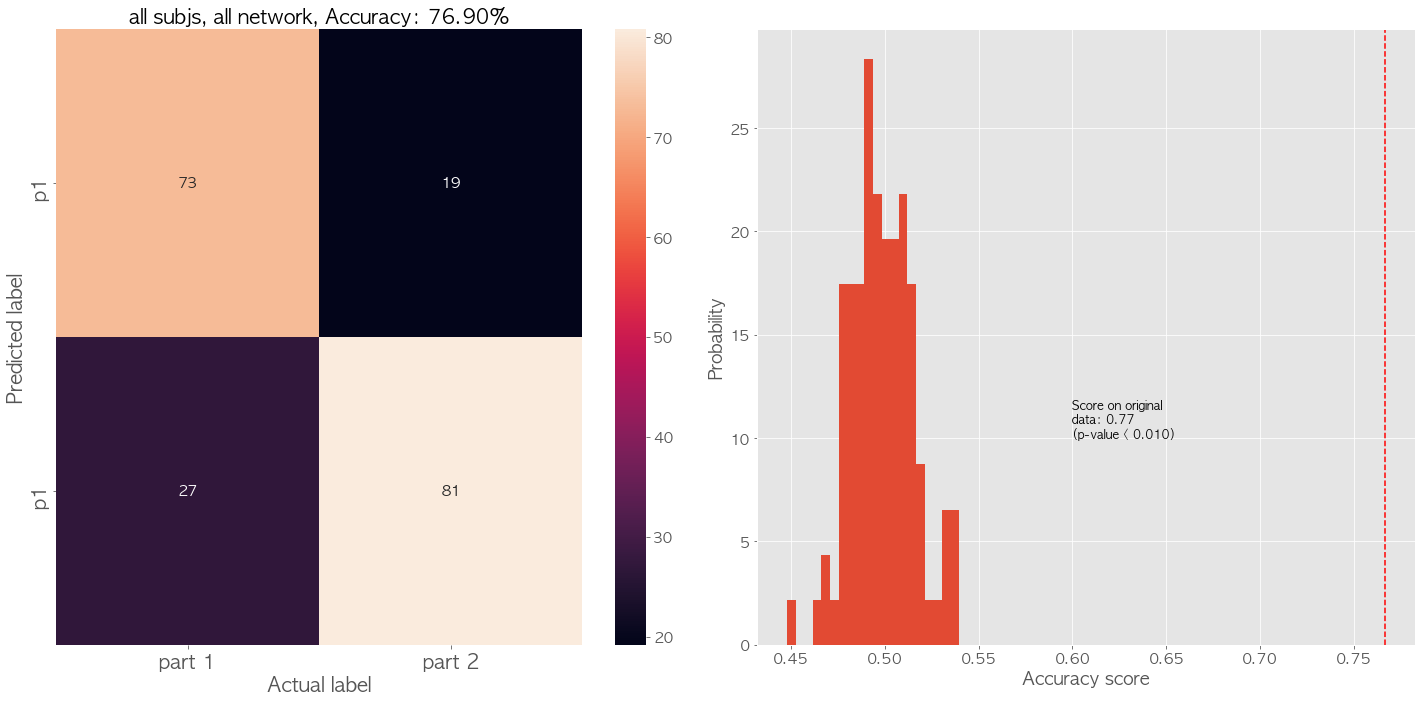

In [19]:
vis = 1
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_permutation_tests_for_classification.html    
if vis == 1:
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(20,10)
    sns.heatmap(confusion_matrix(y_aftrain,y_train)/(y_train.shape[0]/2)*100,
          annot=True, fmt='2.0f', cbar = True, ax = axes[0])
    axes[0].set_title('all subjs, all network, Accuracy: %.2f%%' % (accuracy_score(y_train, y_aftrain)*100.0), 
                           fontsize=20) 
    axes[0].set_ylabel('Predicted label', fontsize=20);
    axes[0].set_xlabel('Actual label', fontsize=20);
    axes[0].tick_params(labelsize=20) 
    axes[0].set_xticklabels(['part 1','part 2'])
    axes[0].set_yticklabels(['p1','p1'])

    axes[1].hist(perm_scores_act, bins=20, density=True)
    axes[1].axvline(score_act, ls="--", color="r")
    score_label = f"Score on original\ndata: {score_act:.2f}\n(p-value < {pvalue_act:.3f})"
    axes[1].text(0.6, 10, score_label, fontsize=12)
    axes[1].set_xlabel("Accuracy score")
    _ = axes[1].set_ylabel("Probability")
    plt.tight_layout()

In [20]:
print(classification_report(y_train, y_aftrain))
cv_results

              precision    recall  f1-score   support

           1       0.79      0.73      0.76       552
           2       0.75      0.81      0.78       552

    accuracy                           0.77      1104
   macro avg       0.77      0.77      0.77      1104
weighted avg       0.77      0.77      0.77      1104



{'fit_time': array([0.121876  , 0.11892986, 0.11858296, 0.11947799, 0.12056518,
        0.11664319, 0.12062287, 0.11841607, 0.11859202, 0.12138486,
        0.11693716, 0.11780405, 0.11878037, 0.11990118, 0.12294817,
        0.12406802, 0.118572  , 0.12062907, 0.11954713, 0.11815238]),
 'score_time': array([0.00163412, 0.00080299, 0.00093293, 0.00082684, 0.00081897,
        0.00096774, 0.00082111, 0.00092697, 0.00092888, 0.00080109,
        0.00080276, 0.00078082, 0.00085282, 0.00080895, 0.00086284,
        0.00078821, 0.00080109, 0.0008502 , 0.00090098, 0.00078368]),
 'test_score': array([0.76      , 0.77586207, 0.85      , 0.5625    , 0.75862069,
        0.87931034, 0.77586207, 0.65517241, 0.86206897, 0.68518519,
        0.82142857, 0.7037037 , 0.85      , 0.82692308, 0.66      ,
        0.74074074, 0.75      , 0.88888889, 0.80769231, 0.71428571])}

### Test

In [21]:
subj_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [22]:
## Parameters
vis = 1
net = 10
net_nidx = [10, 0, 1, 2, 3, 4, 5, 6, 7, 9]

# classifier, 1 - rdige, 2 - logreg, 3 - lSVM, 4 - rbfSVM
clf = 1

# standardization method, 1 - case, 2 - feature, 3 - none
std_opt = 2
output_name = ('sFC_mvpc_grp_opt%d_std%d.csv' % (sOpt, std_opt))

results_allSubj = [];
x_targ_sn = [];
x_net = [];
x_classifier = [];
x_vAcc = [];
x_vAuc = [];
x_p1_vAcc = [];
x_p2_vAcc = [];
x_perm_vAcc = [];
x_perm_vChance = [];
x_perm_vPval = [];
x_tAcc = [];
x_tAuc = [];
x_p1_tAcc = [];
x_p2_tAcc = [];
x_perm_tAcc = [];
x_perm_tChance = [];
x_perm_tPval = [];


## Data Preparation
gdf_1 = pd.merge(bh, data, on = ['sn','idx'])
gdf_2 = gdf_1[(gdf_1['con']>0) & (gdf_1['corr']==1)]

for this_sub in subj_idx:
    
    train_subj = deepcopy(subj_idx)
    train_subj.remove(this_sub)
    test_subj = this_sub
    
    data_train = gdf_2.loc[gdf_2["sn"] != test_subj,:]
    data_test = gdf_2.loc[gdf_2["sn"] == test_subj,:]
    
    x_train_r = np.array(data_train.loc[:,"v1":])
    x_train_r = x_train_r.astype('float32')
    y_train = np.array(data_train.loc[:,"con"])
    y_train = y_train.astype('int')
    groups = np.array(data_train.loc[:,"run"])
    groups = groups.astype('int')
    
    x_test_r = np.array(data_test.loc[:,"v1":])
    x_test_r = x_test_r.astype('float32')
    y_test = np.array(data_test.loc[:,"con"])
    y_test = y_test.astype('int')

    for net in net_nidx:

        if net == 10:
            x_train = deepcopy(x_train_r)
            x_test = deepcopy(x_test_r)
        elif net != 10:
            x_train = deepcopy(x_train_r[:,net_loc==net])
            x_test = deepcopy(x_test_r[:,net_loc==net])

        if std_opt == 1: # case standardization
            scaler_train = StandardScaler()
            x_train_z = np.transpose(x_train)
            x_train_z = scaler_train.fit_transform(x_train_z)
            x_train_z = np.transpose(x_train_z)
            x_train = x_train_z

            scaler_test = StandardScaler()
            x_test_z = np.transpose(x_test)
            x_test_z = scaler_test.fit_transform(x_test_z)
            x_test_z = np.transpose(x_test_z)
            x_test = x_test_z

        elif std_opt == 2: # feature standardization
            scaler = StandardScaler()
            x_train_z = scaler.fit_transform(x_train)
            x_train = x_train_z

            x_test_z = scaler.transform(x_test)
            x_test = x_test_z

        elif std_opt == 3: # no standardization
            x_train = x_train
            x_test = x_test

        x_train = np.nan_to_num(x_train, copy=False)
        x_test = np.nan_to_num(x_test, copy=False)

        # feature selection
        from sklearn.feature_selection import SelectKBest, f_classif
        X_indices = np.arange(x_train.shape[-1]) # feature 인덱스를 반환한다.
        selector = SelectKBest(f_classif, k="all") 
        selector.fit(x_train, y_train)
        # alpha = 1
        alpha = 1
        is_support = selector.pvalues_ < alpha
        # bonf_corrected_alpha = alpha/len(X_indices)
        # is_support = selector.pvalues_ < bonf_corrected_alpha

        x_train_fs = x_train[:,is_support]
        x_test_fs = x_test[:,is_support]

        print('-'*30)
        print("testSubj: %d,  net %d, std %d, clasif %d\n"
              % (test_subj, net, std_opt, clf))
        print("FS before - train %s, test %s\n"
              % (x_train.shape, x_test.shape))
        print("FS after - a = %0.3f, train %s, test %s\n"
              % (alpha, str(x_train_fs.shape), str(x_test_fs.shape)))

        ## Classifier Setting
        Classif = RidgeClassifier(alpha=10.0)
        # class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, 
        #                                            normalize=False, copy_X=True, 
        #                                            max_iter=None, tol=0.001, 
        #                                            class_weight=None, 
        #                                            solver='auto', random_state=None)
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html?highlight=ridgeclassifier#sklearn.linear_model.RidgeClassifier
        # Classif = svm.SVC(kernel='rbf', decision_function_shape='ovr')

        ### training & validation
        logo = LeaveOneGroupOut()
        # kfold = StratifiedKFold(n_splits=5, random_state=5, shuffle=True) # for same class dist cv=kfold
        y_aftrain = cross_val_predict(Classif, x_train_fs, y_train, cv=logo, groups=groups)
        cv_results = cross_validate(Classif, x_train_fs, y_train, cv=logo, groups=groups)
        valid_acc = accuracy_score(y_train, y_aftrain)*100.0

        y_train_bn = label_binarize(y_train, classes=[1,2])
        y_aftrain_bn = label_binarize(y_aftrain, classes=[1,2])
        valid_auc = roc_auc_score(y_train_bn, y_aftrain_bn, average=None)

        p1_train_idx1 = y_train==1
        p2_train_idx1 = y_train==2

        p1_train = y_train[p1_train_idx1]
        p1_aftrain = y_aftrain[p1_train_idx1]

        p2_train = y_train[p2_train_idx1]
        p2_aftrain = y_aftrain[p2_train_idx1]

        p1_train_acc = accuracy_score(p1_train, p1_aftrain)*100.0
        p2_train_acc = accuracy_score(p2_train, p2_aftrain)*100.0

        # permutation test for training & validation
        # score_train, perm_scores_train, pvalue_train = permutation_test_score(
        #     Classif, x_train_fs, y_train, scoring="accuracy", cv=logo, groups=groups, n_permutations=1000)
        score_train = 0
        perm_scores_train = 0
        pvalue_train = 0

        ### testing
        Classif.fit(x_train_fs, y_train)
        y_pred = Classif.predict(x_test_fs)
        testing_acc = accuracy_score(y_test, y_pred)*100.0

        y_test_bn = label_binarize(y_test, classes=[1,2])
        y_pred_bn = label_binarize(y_pred, classes=[1,2])
        testing_auc = roc_auc_score(y_test_bn, y_pred_bn, average=None)

        p1_test_idx1 = y_test==1
        p2_test_idx1 = y_test==2

        p1_test = y_test[p1_test_idx1]
        p1_pred = y_pred[p1_test_idx1]
        p2_test = y_test[p2_test_idx1]
        p2_pred = y_pred[p2_test_idx1]

        p1_test_acc = accuracy_score(p1_test, p1_pred)*100.0
        p2_test_acc = accuracy_score(p2_test, p2_pred)*100.0

        # permutation test for testing
        score_test, perm_scores_test, pvalue_test = permutation_test_score(
            Classif, x_test_fs, y_test, scoring="accuracy", n_permutations=100)

        ### saving
        results_allSubj
        x_targ_sn.append(test_subj)
        x_net.append(net)
        x_classifier.append(clf)
        x_vAcc.append(valid_acc)
        x_vAuc.append(np.mean(valid_auc)*100)
        x_p1_vAcc.append(p1_train_acc)
        x_p2_vAcc.append(p2_train_acc)
        x_perm_vAcc.append(score_train)
        x_perm_vChance.append(np.mean(perm_scores_train))
        x_perm_vPval.append(pvalue_train)
        x_tAcc.append(testing_acc)
        x_tAuc.append(np.mean(testing_auc)*100)
        x_p1_tAcc.append(p1_test_acc)
        x_p2_tAcc.append(p2_test_acc)
        x_perm_tAcc.append(score_test)
        x_perm_tChance.append(np.mean(perm_scores_test))
        x_perm_tPval.append(pvalue_test)
    
    print("-------------------------- Done ----------------------------\n\n")
    
        
# final saving
results_allSubj = pd.DataFrame({'tSN': x_targ_sn,
                            'net': x_net,
                            'classifier': x_classifier,                            
                            'vAcc': x_vAcc,
                            'vAuc': x_vAuc,
                            'p1_vAcc': x_p1_vAcc,
                            'p2_vAcc': x_p2_vAcc,
                            'perm_vAcc': x_perm_vAcc,
                            'perm_vChance': x_perm_vChance,
                            'perm_vPval': x_perm_vPval,
                            'tAcc': x_tAcc,
                            'tAuc': x_tAuc,
                            'p1_tAcc': x_p1_tAcc,
                            'p2_tAcc': x_p2_tAcc,
                            'perm_tAcc': x_perm_tAcc,
                            'perm_tChance': x_perm_tChance,
                            'perm_tPval': x_perm_tPval})

results_allSubj.to_csv(output_name, mode='w', index=False)    
    
    


------------------------------
testSubj: 1,  net 10, std 2, clasif 1

FS before - train (1054, 7381), test (50, 7381)

FS after - a = 1.000, train (1054, 7381), test (50, 7381)

------------------------------
testSubj: 1,  net 0, std 2, clasif 1

FS before - train (1054, 6288), test (50, 6288)

FS after - a = 1.000, train (1054, 6288), test (50, 6288)

------------------------------
testSubj: 1,  net 1, std 2, clasif 1

FS before - train (1054, 45), test (50, 45)

FS after - a = 1.000, train (1054, 45), test (50, 45)

------------------------------
testSubj: 1,  net 2, std 2, clasif 1

FS before - train (1054, 45), test (50, 45)

FS after - a = 1.000, train (1054, 45), test (50, 45)

------------------------------
testSubj: 1,  net 3, std 2, clasif 1

FS before - train (1054, 325), test (50, 325)

FS after - a = 1.000, train (1054, 325), test (50, 325)

------------------------------
testSubj: 1,  net 4, std 2, clasif 1

FS before - train (1054, 276), test (50, 276)

FS after - a = 1.0

------------------------------
testSubj: 5,  net 6, std 2, clasif 1

FS before - train (1046, 276), test (58, 276)

FS after - a = 1.000, train (1046, 276), test (58, 276)

------------------------------
testSubj: 5,  net 7, std 2, clasif 1

FS before - train (1046, 6), test (58, 6)

FS after - a = 1.000, train (1046, 6), test (58, 6)

------------------------------
testSubj: 5,  net 9, std 2, clasif 1

FS before - train (1046, 28), test (58, 28)

FS after - a = 1.000, train (1046, 28), test (58, 28)

-------------------------- Done ----------------------------


------------------------------
testSubj: 6,  net 10, std 2, clasif 1

FS before - train (1046, 7381), test (58, 7381)

FS after - a = 1.000, train (1046, 7381), test (58, 7381)

------------------------------
testSubj: 6,  net 0, std 2, clasif 1

FS before - train (1046, 6288), test (58, 6288)

FS after - a = 1.000, train (1046, 6288), test (58, 6288)

------------------------------
testSubj: 6,  net 1, std 2, clasif 1

FS bef

------------------------------
testSubj: 10,  net 2, std 2, clasif 1

FS before - train (1050, 45), test (54, 45)

FS after - a = 1.000, train (1050, 45), test (54, 45)

------------------------------
testSubj: 10,  net 3, std 2, clasif 1

FS before - train (1050, 325), test (54, 325)

FS after - a = 1.000, train (1050, 325), test (54, 325)

------------------------------
testSubj: 10,  net 4, std 2, clasif 1

FS before - train (1050, 276), test (54, 276)

FS after - a = 1.000, train (1050, 276), test (54, 276)

------------------------------
testSubj: 10,  net 5, std 2, clasif 1

FS before - train (1050, 91), test (54, 91)

FS after - a = 1.000, train (1050, 91), test (54, 91)

------------------------------
testSubj: 10,  net 6, std 2, clasif 1

FS before - train (1050, 276), test (54, 276)

FS after - a = 1.000, train (1050, 276), test (54, 276)

------------------------------
testSubj: 10,  net 7, std 2, clasif 1

FS before - train (1050, 6), test (54, 6)

FS after - a = 1.000, tra

-------------------------- Done ----------------------------


------------------------------
testSubj: 16,  net 10, std 2, clasif 1

FS before - train (1054, 7381), test (50, 7381)

FS after - a = 1.000, train (1054, 7381), test (50, 7381)

------------------------------
testSubj: 16,  net 0, std 2, clasif 1

FS before - train (1054, 6288), test (50, 6288)

FS after - a = 1.000, train (1054, 6288), test (50, 6288)

------------------------------
testSubj: 16,  net 1, std 2, clasif 1

FS before - train (1054, 45), test (50, 45)

FS after - a = 1.000, train (1054, 45), test (50, 45)

------------------------------
testSubj: 16,  net 2, std 2, clasif 1

FS before - train (1054, 45), test (50, 45)

FS after - a = 1.000, train (1054, 45), test (50, 45)

------------------------------
testSubj: 16,  net 3, std 2, clasif 1

FS before - train (1054, 325), test (50, 325)

FS after - a = 1.000, train (1054, 325), test (50, 325)

------------------------------
testSubj: 16,  net 4, std 2, clasif

------------------------------
testSubj: 20,  net 5, std 2, clasif 1

FS before - train (1052, 91), test (52, 91)

FS after - a = 1.000, train (1052, 91), test (52, 91)

------------------------------
testSubj: 20,  net 6, std 2, clasif 1

FS before - train (1052, 276), test (52, 276)

FS after - a = 1.000, train (1052, 276), test (52, 276)

------------------------------
testSubj: 20,  net 7, std 2, clasif 1

FS before - train (1052, 6), test (52, 6)

FS after - a = 1.000, train (1052, 6), test (52, 6)

------------------------------
testSubj: 20,  net 9, std 2, clasif 1

FS before - train (1052, 28), test (52, 28)

FS after - a = 1.000, train (1052, 28), test (52, 28)

-------------------------- Done ----------------------------


------------------------------
testSubj: 21,  net 10, std 2, clasif 1

FS before - train (1048, 7381), test (56, 7381)

FS after - a = 1.000, train (1048, 7381), test (56, 7381)

------------------------------
testSubj: 21,  net 0, std 2, clasif 1

FS befor

In [23]:
results_allSubj.head()

,tSN,net,classifier,vAcc,vAuc,p1_vAcc,p2_vAcc,perm_vAcc,perm_vChance,perm_vPval,tAcc,tAuc,p1_tAcc,p2_tAcc,perm_tAcc,perm_tChance,perm_tPval
0,1,10,1,84.724858,84.724858,83.870968,85.578748,0,0.0,0,78.0,78.0,60.0,96.0,0.80,0.5076,0.009901
1,1,0,1,83.396584,83.396584,82.542694,84.250474,0,0.0,0,80.0,80.0,68.0,92.0,0.80,0.5120,0.009901
2,1,1,1,74.193548,74.193548,72.106262,76.280835,0,0.0,0,52.0,52.0,76.0,28.0,0.64,0.5202,0.059406
3,1,2,1,54.269450,54.269450,54.838710,53.700190,0,0.0,0,56.0,56.0,44.0,68.0,0.56,0.4896,0.237624
4,1,3,1,73.149905,73.149905,70.588235,75.711575,0,0.0,0,72.0,72.0,60.0,84.0,0.72,0.4982,0.009901


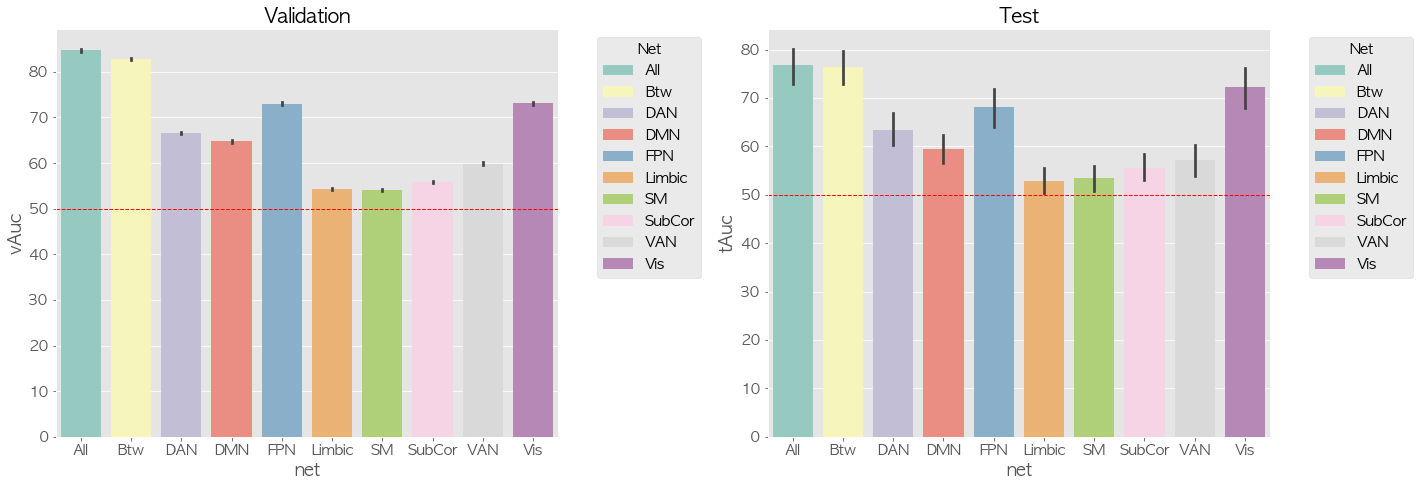

In [24]:
results_allSubj['classifier'] = results_allSubj['classifier'].replace([1, 2, 3, 4],
                                                              ['ridge', 'logreg', 'lSVM', 'rbfSVM'])
results_allSubj['net'] = results_allSubj['net'].replace([10, 0, 1, 2, 3, 4, 5, 6, 7, 9],
                                    ['All', 'Btw', 'Vis', 'SM', 'FPN', 'VAN', 'DAN', 'DMN', 'Limbic', 'SubCor'])

stdf3_1 = (results_allSubj
         .filter(['tSN', 'classifier', 'net', 'vAuc'])
         .groupby(['tSN', 'classifier', 'net'])
         .agg('mean')).reset_index()

#plt.figure(figsize=(16, 6))

stdf3_2 = (results_allSubj
         .filter(['tSN', 'classifier', 'net', 'tAuc'])
         .groupby(['tSN', 'classifier', 'net'])
         .agg('mean')).reset_index()



fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20,7)
g1 = sns.barplot(data=stdf3_1, x="net", y="vAuc", hue="net", 
            dodge=False, ax=axes[0], palette="Set3")
axes[0].axhline(y=50, xmin=0, xmax=1, linewidth = 1, color='red', linestyle='dashed')
g1.legend(loc='upper right', title='Net',
         bbox_to_anchor=(1.3, 1))
axes[0].set_title('Validation', fontsize=20) 
g2 = sns.barplot(data=stdf3_2, x="net", y="tAuc", hue="net", 
            dodge=False, ax=axes[1], palette="Set3")
axes[1].axhline(y=50, xmin=0, xmax=1, linewidth = 1, color='red', linestyle='dashed')
g2.legend(loc='upper right', title='Net',
         bbox_to_anchor=(1.3, 1))
axes[1].set_title('Test', fontsize=20) 
plt.tight_layout()



In [25]:
(results_allSubj
 .filter(['tSN', 'classifier', 'net', 'vAuc'])
 .groupby(['classifier', 'net'])
 .agg('mean')).reset_index()

#plt.figure(figsize=(16, 6))

(results_allSubj
 .filter(['tSN', 'classifier', 'net', 'tAuc'])
 .groupby(['classifier', 'net'])
 .agg('mean')).reset_index()

,classifier,net,tSN,tAuc
0,ridge,All,10.95,76.744097
1,ridge,Btw,10.95,76.416541
2,ridge,DAN,10.95,63.458081
3,ridge,DMN,10.95,59.453520
4,ridge,FPN,10.95,68.071277
5,ridge,Limbic,10.95,52.931465
6,ridge,SM,10.95,53.396023
7,ridge,SubCor,10.95,55.599545
8,ridge,VAN,10.95,57.132921
9,ridge,Vis,10.95,72.362759


# Network Analysis

* 연결성 패턴을 대상으로 네트워크 분석을 수행한다. 

In [17]:
#data
## Data Preparation
gdf_1 = pd.merge(bh, data, on = ['sn','idx'])
gdf_2 = gdf_1[(gdf_1['con']>0)]

In [18]:
yeo122_coords = pd.read_csv("yeo_18net.csv", index_col="LabelNum")
yeo122_coords = (yeo122_coords
                .filter(['LabelNum', 'MNI_X', 'MNI_Y', 'MNI_Z']))
print(yeo122_coords.shape)
yeo122_coords.head()

(122, 3)


,MNI_X,MNI_Y,MNI_Z
LabelNum,,,
1,-8,-98,-8
2,-32,-88,-6
3,-8,-78,6
4,-14,-58,-4
5,-8,-82,28


In [19]:
yeo122_labels = pd.read_csv("yeo_18net.csv")
yeo122_labels = (yeo122_labels
                .filter(['LabelNum', 'Net9Num','Full Component Name', 'Net9Name']))
labels = (yeo122_labels.reset_index()
          .filter(['Full Component Name', 'LabelNum', 'Net9Num', 'Net9Name']))
print(yeo122_labels.shape)
labels['Net9Name'] = labels['Net9Name'].replace(['Cont', 'Sal/VA'], ['FPN', 'VAN'])
labels.head()

(122, 4)


,Full Component Name,LabelNum,Net9Num,Net9Name
0,striate cortex,1,1,Vis
1,extrastriate cortex,2,1,Vis
2,striate calcarine,3,1,Vis
3,extra-striate inferior,4,1,Vis
4,extra-striate superior,5,1,Vis


In [20]:
ci =  np.array(labels)[:,3]
df_ci = pd.DataFrame(ci)
df_ci = df_ci.rename(columns={0:'net'})

ci_raw =  np.array(labels)[:,2]
ci_raw = ci_raw.astype(int)
#ci_raw

In [21]:
net_loc_name['loc'] = net_loc_name['loc'].replace(['Vis', 'SM', 'FPN', 'VAN', 'DAN', 'DMN', 'Limbic', 'TP', 'SubCor', 'btw'],
                                                 ['Vis', 'SM', 'FPN', 'VAN', 'DAN', 'DMN', 'Limb', 'TP', 'SubCor', 'Btw'])

In [22]:
df_ci.net.unique()

array(['Vis', 'SM', 'DAN', 'VAN', 'Limb', 'FPN', 'DMN', 'TP', 'SubCor'],
      dtype=object)

In [23]:
np.unique(net_loc_name['loc'])

array(['Btw', 'DAN', 'DMN', 'FPN', 'Limb', 'SM', 'SubCor', 'TP', 'VAN',
       'Vis'], dtype=object)

In [24]:
np.unique(df_ci)

array(['DAN', 'DMN', 'FPN', 'Limb', 'SM', 'SubCor', 'TP', 'VAN', 'Vis'],
      dtype=object)

In [26]:
subj_idx = [1, 2, 3, 4, 5, 6,
            7, 8, 9, 10, 11,
            13, 14, 15, 16, 17,
            18, 19, 20, 21]

part_idx = [1, 2]  # 1: part1, 2: part2

movie_idx = [2, 9, 10, 13, 15,
             24, 25, 33, 44, 49,
             58, 62, 68, 74, 81,
             86, 87, 90, 97, 104,
             112, 113, 115, 202, 217,
             222, 230, 234, 235, 777]

sign_idx = [1, 2, 3]  # 1: all, 2: pos, 3: neg

net_idx = ['Vis', 'SM', 'FPN',
           'VAN', 'DAN', 'DMN',
           'TP', 'Limb', 'SubCor']

results_sum = []
x_subj = []
x_idx = []
x_part = []
x_net = []
x_fc = [] # net
x_pfc = [] # net
x_nfc = [] # net
x_stp = [] # net
x_stn = [] # net
x_w_p = []
x_w_n = []
x_m1 = []
x_m2 = []
x_le = [] # net
x_cc = [] # net
x_ge = []
x_mdz = [] # net
x_pc_p = [] # net
x_pc_n = [] # net

output_name = ('sFC_net_v2.csv')
for sidx, subj in enumerate(subj_idx):
    dSubj = gdf_2[(gdf_2['sn'] == subj)]
    print('-'*30)
    print('\nsubj %d' % (subj))

    for midx, movie in enumerate(movie_idx):
        dMovie = dSubj[(dSubj['idx'] == movie)]

        for pidx, part in enumerate(part_idx):
            dPart = dMovie[(dMovie['con'] == part)].loc[:, 'v1':]
            dPart = np.array(dPart)[0]
            dPart_mat = sp.spatial.distance.squareform(dPart)

            # Split Edge & Matrix
            sign_edge = deepcopy(dPart)
            sign_edge_pos = deepcopy(dPart)
            sign_edge_pos[sign_edge_pos<0] = 0
            sign_edge_neg = deepcopy(dPart)
            sign_edge_neg[sign_edge_neg>0] = 0
            
            sign_edge = pd.concat([net_loc_name, pd.DataFrame(sign_edge)], axis = 1)
            sign_edge_pos = pd.concat([net_loc_name, pd.DataFrame(sign_edge_pos)], axis = 1)
            sign_edge_neg = pd.concat([net_loc_name, pd.DataFrame(sign_edge_neg)], axis = 1)
            
            sign_mat = deepcopy(dPart_mat)
            sign_mat_pos = deepcopy(dPart_mat)
            sign_mat_pos[sign_mat_pos < 0] = 0
            sign_mat_neg = deepcopy(dPart_mat)
            sign_mat_neg[sign_mat_neg > 0] = 0
            #sign_mat_neg = np.abs(deepcopy(sign_mat_neg))
            
            ## Connectivity Measures
            
            # 1) sum
            all_fc = (sign_edge
                   .filter([0])
                   .agg('mean')).values[0]
            net_fc = (sign_edge
                   .groupby(['loc'])
                   .agg('mean').reset_index())

            
            # 2) pos
            all_pos =(sign_edge_pos
                      .filter([0])
                      .agg('mean')).values[0] 
            net_pos = (sign_edge_pos
                       .groupby(['loc'])
                       .agg('mean').reset_index())
            
            # 3) neg
            all_neg =(sign_edge_neg
                      .filter([0])
                      .agg('mean')).values[0] 
            net_neg = (sign_edge_neg
                       .groupby(['loc'])
                       .agg('mean').reset_index())
            
            ## Strength measures
            st_p, st_n, w_p, w_n = bct.strengths_und_sign(sign_mat)
            st_p = pd.DataFrame(st_p)
            st_p.columns = ['score']
            st_pci = pd.concat([st_p, df_ci], axis=1)
            st_p_tmp = (st_pci
                  .groupby(['net'])
                  .agg('mean')).reset_index()
            st_p_all = (st_pci
                  .agg('mean')).reset_index().values[0][1]

            st_n = pd.DataFrame(st_n)
            st_n.columns = ['score']
            st_nci = pd.concat([st_n, df_ci], axis=1)
            st_n_tmp = (st_nci
                  .groupby(['net'])
                  .agg('mean')).reset_index()
            st_n_all = (st_nci
                  .agg('mean')).reset_index().values[0][1]

            
            ## Segregation measures
            # 1) Modularity
            M1, q1 = bct.community_louvain(W=sign_mat, gamma=1,
                                         ci=ci_raw, B='negative_asym',
                                         seed=22)
            M2, q2 = bct.modularity_und_sign(W=sign_mat, ci=ci_raw, qtype='sta')

            # 2) Local Efficiency
            le = bct.efficiency_wei(sign_mat_pos, local=True)

            le = pd.DataFrame(le)
            le.columns = ['score']
            leci = pd.concat([le, df_ci], axis=1)
            le_tmp = (leci
                      .groupby(['net'])
                      .agg('mean')).reset_index()
            le_all = (leci
                      .agg('mean')).reset_index().values[0][1]
            
            # 3) Clustering Coefficienct
            cc = bct.clustering_coef_wu(sign_mat_pos)
            cc = pd.DataFrame(cc)
            cc.columns = ['score']
            ccci = pd.concat([cc, df_ci], axis=1)
            cc_tmp = (ccci
                      .groupby(['net'])
                      .agg('mean')).reset_index()
            cc_all = (ccci
                      .agg('mean')).reset_index().values[0][1]            

            ## Integration Measures

            # Global Efficiency
            ge = bct.efficiency_wei(sign_mat_pos, local=False)
            
            ## Centrality Measures
            # 1) within-module degree z-score
            mdz = bct.module_degree_zscore(sign_mat, ci_raw)
            mdz = pd.DataFrame(mdz)
            mdz.columns = ['score']
            mdzci = pd.concat([mdz, df_ci], axis=1)
            mdz_tmp = (mdzci
                       .groupby(['net'])
                       .agg('mean')).reset_index()
            mdz_all = (mdzci
                       .agg('mean')).reset_index().values[0][1]


            # 2) participation coefficient
            [pc_p, pc_n]=bct.participation_coef_sign(sign_mat, ci_raw)

            pc_p = pd.DataFrame(pc_p)
            pc_p.columns = ['score']
            pc_p_ci = pd.concat([pc_p, df_ci], axis=1)
            #pc_p_ci.score[pc_p_ci['score'] < 0] = 0
            #pc_p_ci.score[pc_p_ci['score'] > 1] = 1
            pc_p_tmp = (pc_p_ci
                      .groupby(['net'])
                      .agg('mean')).reset_index()     
            pc_p_all = (pc_p_ci
                      .agg('mean')).reset_index().values[0][1]     
            
            pc_n = pd.DataFrame(pc_n)
            pc_n.columns = ['score']
            pc_n_ci = pd.concat([pc_n, df_ci], axis=1)
            #pc_n_ci.score[pc_n_ci['score'] < 0] = 0
            #pc_n_ci.score[pc_n_ci['score'] > 1] = 1
            pc_n_tmp = (pc_n_ci
                      .groupby(['net'])
                      .agg('mean')).reset_index()                 
            pc_n_all = (pc_n_ci
                      .agg('mean')).reset_index().values[0][1]
            
            # save data - all net
            x_subj.append(subj)
            x_idx.append(movie)
            x_part.append(part)
            x_net.append('All')
            x_fc.append(all_fc) # net
            x_pfc.append(all_pos) # net
            x_nfc.append(all_neg) # net
            x_stp.append(st_p_all) # net
            x_stn.append(st_n_all) # net
            x_w_p.append(w_p)
            x_w_n.append(w_n)
            x_m1.append(q1)
            x_m2.append(q2)
            x_le.append(le_all) # net
            x_cc.append(cc_all) # net
            x_ge.append(ge)
            x_mdz.append(mdz_all) # net
            x_pc_p.append(pc_p_all) # net
            x_pc_n.append(pc_n_all) # net
            
            for nidx, net in enumerate(net_idx):
                x_subj.append(subj)
                x_idx.append(movie)
                x_part.append(part)
                x_net.append(net)
                x_fc.append(net_fc[net_fc['loc'] == net].values[0][1]) # net
                x_pfc.append(net_pos[net_pos['loc'] == net].values[0][1]) # net
                x_nfc.append(net_neg[net_neg['loc'] == net].values[0][1]) # net
                x_stp.append(st_p_tmp[st_p_tmp['net']==net].values[0][1]) # net
                x_stn.append(st_n_tmp[st_n_tmp['net']==net].values[0][1]) # net
                x_w_p.append(w_p)
                x_w_n.append(w_n)
                x_m1.append(q1)
                x_m2.append(q2)
                x_le.append(le_tmp[le_tmp['net']==net].values[0][1]) # net
                x_cc.append(cc_tmp[cc_tmp['net']==net].values[0][1]) # net
                x_ge.append(ge)
                x_mdz.append(mdz_tmp[mdz_tmp['net']==net].values[0][1]) # net
                x_pc_p.append(pc_p_tmp[pc_p_tmp['net']==net].values[0][1]) # net
                x_pc_n.append(pc_n_tmp[pc_p_tmp['net']==net].values[0][1]) # net

# final saving
results_net = pd.DataFrame({'sn': x_subj,
                            'idx': x_idx,
                            'net': x_net,
                            'part': x_part,
                            'fc':x_fc,
                            'p_fc':x_pfc,
                            'n_fc':x_nfc,
                            'p_st':x_stp,
                            'n_st':x_stn,                            
                            'p_w':x_w_p,
                            'n_w':x_w_n,                            
                            'md1': x_m1,
                            'md2': x_m2,                            
                            'cc':x_cc,
                            'le':x_le,
                            'ge':x_ge,
                            'mdz':x_mdz,
                            'p_pc':x_pc_p,
                            'n_pc':x_pc_n, })

results_net.to_csv(output_name, mode='w', index=False)

------------------------------

subj 1
------------------------------

subj 2
------------------------------

subj 3
------------------------------

subj 4
------------------------------

subj 5
------------------------------

subj 6
------------------------------

subj 7
------------------------------

subj 8
------------------------------

subj 9
------------------------------

subj 10
------------------------------

subj 11
------------------------------

subj 13
------------------------------

subj 14
------------------------------

subj 15
------------------------------

subj 16
------------------------------

subj 17
------------------------------

subj 18
------------------------------

subj 19
------------------------------

subj 20
------------------------------

subj 21


In [27]:
results_net.head()

,sn,idx,net,part,fc,p_fc,n_fc,p_st,n_st,p_w,n_w,md1,md2,cc,le,ge,mdz,p_pc,n_pc
0,1,2,All,1,0.009869,0.102889,-0.093020,12.449610,-11.255476,1518.85241,-1373.168048,0.440273,0.099753,0.116328,0.185783,0.21902,3.549074e-17,0.789822,0.800196
1,1,2,Vis,1,0.234341,0.284900,-0.050559,10.287335,-9.862952,1518.85241,-1373.168048,0.440273,0.099753,0.100334,0.162902,0.21902,2.775558e-18,0.822533,0.801731
2,1,2,SM,1,0.379776,0.379776,0.000000,12.593372,-9.827880,1518.85241,-1373.168048,0.440273,0.099753,0.108797,0.176954,0.21902,2.220446e-17,0.794887,0.786048
3,1,2,FPN,1,0.131623,0.177672,-0.046049,12.612886,-11.230622,1518.85241,-1373.168048,0.440273,0.099753,0.114664,0.187425,0.21902,8.540177e-18,0.765395,0.806380
4,1,2,VAN,1,0.198706,0.233637,-0.034931,11.792005,-12.396167,1518.85241,-1373.168048,0.440273,0.099753,0.116951,0.186493,0.21902,-3.700743e-17,0.768366,0.811078


In [35]:
results_net_1 = pd.merge(bh, results_net, on = ['sn','idx'])
results_net_2 = results_net_1[results_net_1['corr']==1]

stdf4 = (results_net_2
 .filter(['sn','idx','net','part','le','ge','p_fc','p_st','md1','md2','cc', 'p_pc'])
# .query('net =="All"')
 .groupby(['sn','net','part'])
 .agg('mean').reset_index())

(stdf4
 .groupby(['net','part'])
 .agg('mean'))

sn         idx        le        ge      p_fc       p_st  \
net    part                                                               
All    1     10.95  116.100832  0.226330  0.257705  0.130656  15.809425   
       2     10.95  116.100832  0.207037  0.240429  0.118966  14.394869   
DAN    1     10.95  116.100832  0.233231  0.257705  0.296328  16.380448   
       2     10.95  116.100832  0.215297  0.240429  0.291701  15.118509   
DMN    1     10.95  116.100832  0.224734  0.257705  0.231502  16.118630   
       2     10.95  116.100832  0.206642  0.240429  0.216453  14.759785   
FPN    1     10.95  116.100832  0.234402  0.257705  0.211743  16.394198   
       2     10.95  116.100832  0.212957  0.240429  0.182624  14.764617   
Limb   1     10.95  116.100832  0.226670  0.257705  0.507096  16.309775   
       2     10.95  116.100832  0.210293  0.240429  0.503438  15.099070   
SM     1     10.95  116.100832  0.221895  0.257705  0.460898  15.576049   
       2     10.95  116.100832  0.201320  0.240429  0.448313  14.141738   
SubCor 1     10.95  116.100832  0.199178  0.257705  0.289547  13.502528   
       2     10.95  116.100832  0.181699  0.240429  0.284860  12.371330   
TP     1     10.95  116.100832  0.235100  0.257705  0.629120  17.096334   
       2     10.95  116.100832  0.215127  0.240429  0.590448  15.436558   
VAN    1     10.95  116.100832  0.229387  0.257705  0.264806  16.014960   
       2     10.95  116.100832  0.212061  0.240429  0.239439  14.681657   
Vis    1     10.95  116.100832  0.216447  0.257705  0.447857  13.875577   
       2     10.95  116.100832  0.192043  0.240429  0.374760  12.238280   

                  md1       md2        cc      p_pc  
net    part                                          
All    1     0.459423  0.083000  0.151336  0.792642  
       2     0.448124  0.087422  0.135186  0.790766  
DAN    1     0.459423  0.083000  0.158647  0.799592  
       2     0.448124  0.087422  0.144056  0.797334  
DMN    1     0.459423  0.083000  0.149051  0.806271  
       2     0.448124  0.087422  0.134163  0.805372  
FPN    1     0.459423  0.083000  0.158275  0.768147  
       2     0.448124  0.087422  0.139495  0.765581  
Limb   1     0.459423  0.083000  0.149308  0.781745  
       2     0.448124  0.087422  0.135660  0.779084  
SM     1     0.459423  0.083000  0.147782  0.805252  
       2     0.448124  0.087422  0.130616  0.805730  
SubCor 1     0.459423  0.083000  0.126943  0.825898  
       2     0.448124  0.087422  0.113338  0.825474  
TP     1     0.459423  0.083000  0.159513  0.784481  
       2     0.448124  0.087422  0.143249  0.786285  
VAN    1     0.459423  0.083000  0.153612  0.786917  
       2     0.448124  0.087422  0.139181  0.782462  
Vis    1     0.459423  0.083000  0.145323  0.794400  
       2     0.448124  0.087422  0.124681  0.794759

In [31]:
stdf5

,sn,net,part,idx,le,ge,p_fc,p_st,md1,md2,cc
0,1,All,1,131.040000,0.244035,0.270521,0.140563,17.008169,0.481265,0.091246,0.168077
1,1,All,2,131.040000,0.212345,0.247465,0.123698,14.967514,0.435930,0.104780,0.139211
2,1,DAN,1,131.040000,0.256284,0.270521,0.319120,18.192351,0.481265,0.091246,0.180049
3,1,DAN,2,131.040000,0.221089,0.247465,0.300037,16.059072,0.435930,0.104780,0.147210
4,1,DMN,1,131.040000,0.235084,0.270521,0.252755,16.692978,0.481265,0.091246,0.158309
...,...,...,...,...,...,...,...,...,...,...,...
395,21,TP,2,112.714286,0.208659,0.227105,0.618288,14.550146,0.463944,0.105610,0.136203
396,21,VAN,1,112.714286,0.214672,0.242269,0.217304,14.711333,0.459731,0.098646,0.139637
397,21,VAN,2,112.714286,0.200245,0.227105,0.197400,13.383622,0.463944,0.105610,0.128187
398,21,Vis,1,112.714286,0.202869,0.242269,0.398553,12.724951,0.459731,0.098646,0.130308


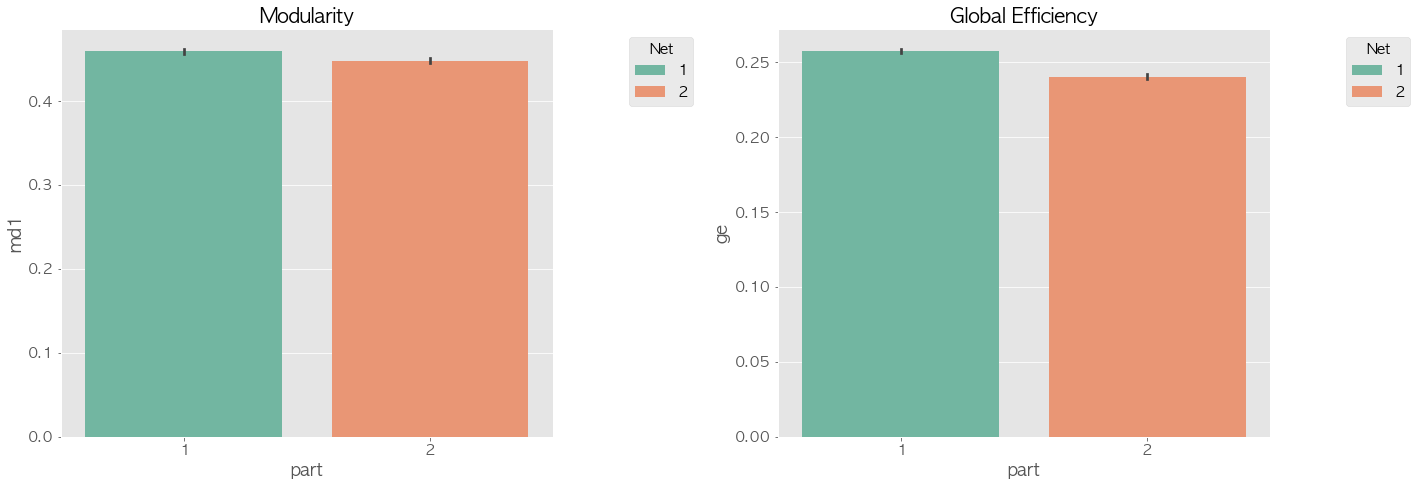

In [32]:
stdf5 = (stdf4)

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20,7)
g1 = sns.barplot(data=stdf5, x="part", y="md1", hue="part", 
            dodge=False, ax=axes[0], palette="Set2")
# axes[0].axhline(y=50, xmin=0, xmax=1, linewidth = 1, color='red', linestyle='dashed')
g1.legend(loc='upper right', title='Net',
         bbox_to_anchor=(1.3, 1))
axes[0].set_title('Modularity', fontsize=20) 
g2 = sns.barplot(data=stdf5, x="part", y="ge", hue="part", 
            dodge=False, ax=axes[1], palette="Set2")
# axes[1].axhline(y=50, xmin=0, xmax=1, linewidth = 1, color='red', linestyle='dashed')
g2.legend(loc='upper right', title='Net',
         bbox_to_anchor=(1.3, 1))
axes[1].set_title('Global Efficiency', fontsize=20) 
plt.tight_layout()


In [33]:
x1 = (stdf5.query('part == 1')['md1'])
x2 = (stdf5.query('part == 2')['md1']) 
pg.ttest(x1, x2, paired=True)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.456025,199,two-sided,9.235948e-18,"[0.01, 0.01]",0.568454,5.535e+14,1.0


In [34]:
x1 = (stdf5.query('part == 1')['ge'])
x2 = (stdf5.query('part == 2')['ge']) 
pg.ttest(x1, x2, paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,63.90873,199,two-sided,1.367270e-134,"[0.02, 0.02]",1.645587,3.762e+130,1.0


In [38]:
stdf6 = (results_net
 .filter(['sn','idx','net','part','p_pc'])
 .query('net != 0')
 .groupby(['sn','net','part'])
 .agg('mean').reset_index())

(stdf6
 .groupby(['net','part'])
 .agg('mean'))

sn         idx      p_pc
net    part                             
All    1     10.95  116.266667  0.792604
       2     10.95  116.266667  0.790706
DAN    1     10.95  116.266667  0.799353
       2     10.95  116.266667  0.797369
DMN    1     10.95  116.266667  0.806341
       2     10.95  116.266667  0.805289
FPN    1     10.95  116.266667  0.768248
       2     10.95  116.266667  0.765484
Limb   1     10.95  116.266667  0.781829
       2     10.95  116.266667  0.778873
SM     1     10.95  116.266667  0.805036
       2     10.95  116.266667  0.805773
SubCor 1     10.95  116.266667  0.825700
       2     10.95  116.266667  0.825574
TP     1     10.95  116.266667  0.784653
       2     10.95  116.266667  0.786174
VAN    1     10.95  116.266667  0.786867
       2     10.95  116.266667  0.782394
Vis    1     10.95  116.266667  0.794276
       2     10.95  116.266667  0.794578